#### http://aishack.in/tutorials/labelling-connected-components-example/
https://courses.cs.washington.edu/courses/cse576/book/ch3.pdf   

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
hm = 'img'
coins = []
for i in os.listdir(hm):
    if 'coins' in i:
        coins.append(i)

In [3]:
from PIL import Image
im = Image.open(os.path.join(hm,coins[0]))
im = np.array(im.resize((300,300),Image.ANTIALIAS))

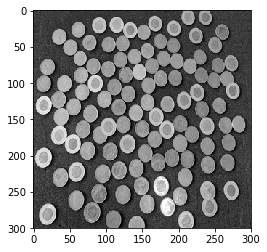

In [4]:
bw_im = np.mean(im,axis=2)/255

plt.imshow(bw_im,**{'cmap':'gray'})

In [5]:
bw_im.min(),bw_im.max()

(0.0, 1.0)

In [6]:
def img_histogram(bw_im,plot=True):
    bw_im = bw_im*100
    
    MaxVal = bw_im.max()
    MaxRow,MaxCol = bw_im.shape

    H = np.zeros(100)
    
    for i in range(MaxRow):
        for j in range(MaxCol):
            H[int(bw_im[i,j]-1)]+=1
    
    if plot==True:
        plt.title('Image Hstogram (black/white)')
        plt.plot(np.arange(100)/100,H)
        
    return H

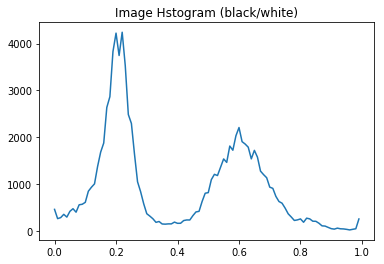

In [7]:
_ = img_histogram(bw_im)

In [8]:
norm = lambda x:(x - x.min())/(x.max()-x.min())

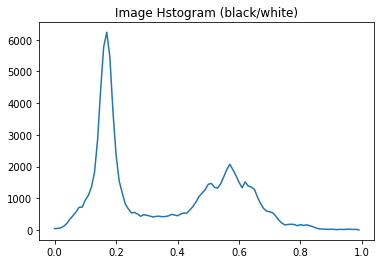

In [9]:
from visTools_v2.core_functions.operations.conv2d import conv2d
from visTools_v2.core_functions.kernels.kernels import kernel
from visTools_v2.core_functions.kernels.gaussian_filter import GaussianFilter

g = GaussianFilter(h=3,w=3,sigma=1)[np.newaxis,np.newaxis,:,:]
smth_im = conv2d(bw_im[np.newaxis,np.newaxis,:,:],g)
smth_im = conv2d(smth_im,kernel().mean)[0,0]
_ = img_histogram(norm(smth_im))

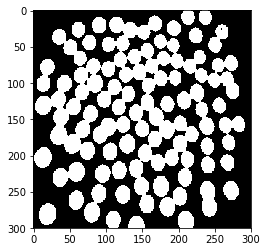

In [10]:
MaxRow,MaxCol = bw_im.shape
bw_mask = np.zeros((MaxRow,MaxCol))
bw_mask = (smth_im<1)&(smth_im>0.4)*1
plt.imshow(bw_mask,**{'cmap':'gray'})

In [11]:
from tqdm import tnrange,tqdm_notebook
from time import sleep

def recursive_connected_components(B):
    LB = -B
    label = 0
    LB = find_components(LB,label)
    return LB
    
def find_components(LB,label):
    MaxRow,MaxCol = LB.shape
    for L in tnrange(MaxRow):
        for P in range(MaxCol):
            if LB[L,P]==-1.0:
                label+=1
                LB = search(LB,label,L,P)
                #sleep(.01)
    return LB

def search(LB,label,L,P):
    
    LB[L,P] = label
    LB_padded = np.pad(LB,((1,1),(1,1)),'constant')
    
    Nset = LB_padded[L:L+3,P:P+3]
    
    
    for i in range(3):
        for j in range(3):
            if (i==1)&(j==1):
                    continue
            if Nset[i,j]==-1:
                if (L-1+i<0)|(P-1+j<0):
                    continue
                
                else:
                    LB=search(LB,label,L-1+i,P-1+j)
    return LB
    

In [12]:
import pylab as pl
from IPython import display as dp
import time

def plot_masks(laballed_mask,save=False):
    for i in np.unique(labelled_mask):

        pl.title('mask:{}'.format(i))

        pl.imshow(labelled_mask==i)
        
        if save:pl.savefig('img/coin_masks/'+'mask_'+str(i))

        dp.clear_output(wait=True)

        dp.display(pl.gcf())

        pl.gcf().clear()

        time.sleep(1.0)


In [13]:
import sys
sys.setrecursionlimit(15000)

B = bw_mask
labelled_mask = recursive_connected_components(B)

HBox(children=(IntProgress(value=0, max=300), HTML(value='')))

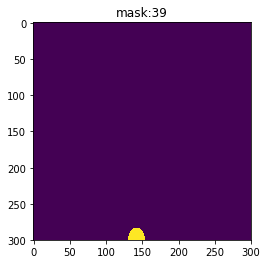

In [14]:
plot_masks(labelled_mask)

In [15]:
from visTools_v2.core_functions.edges import canny

/home/robinson/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


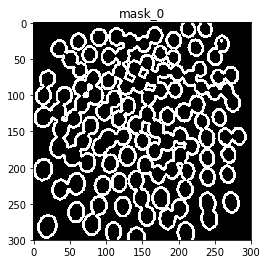

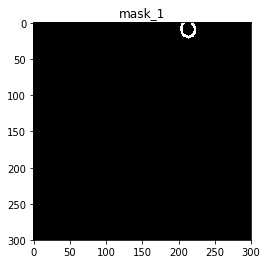

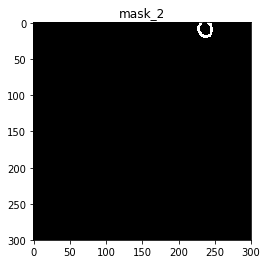

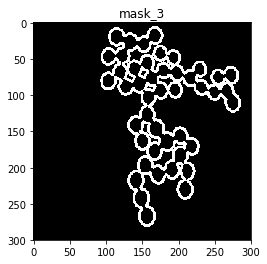

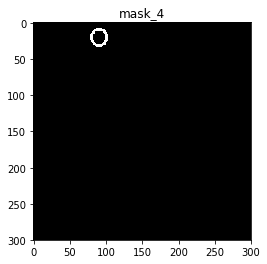

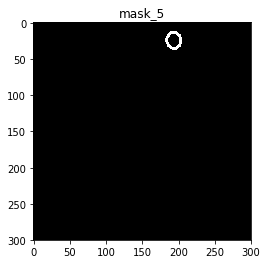

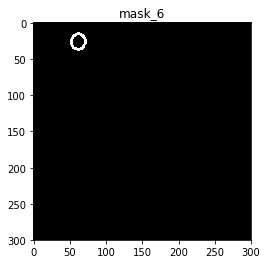

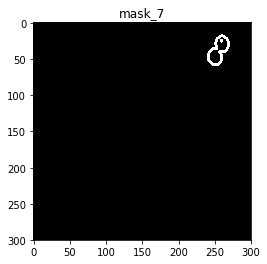

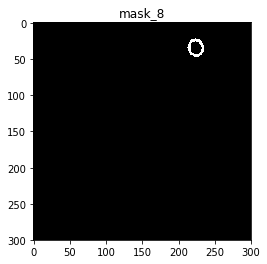

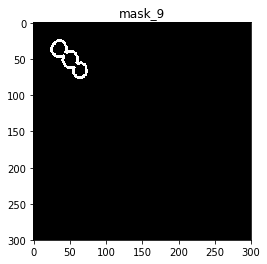

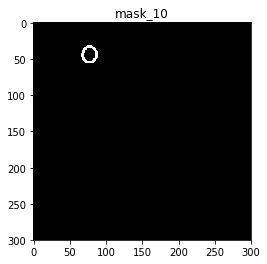

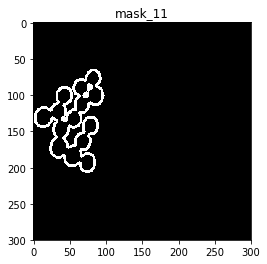

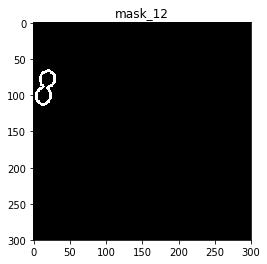

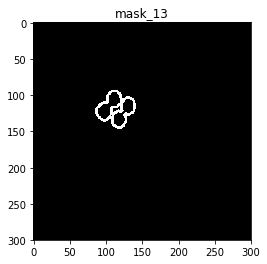

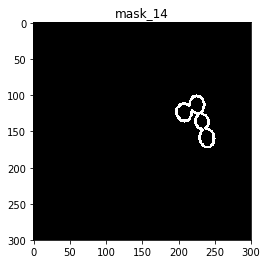

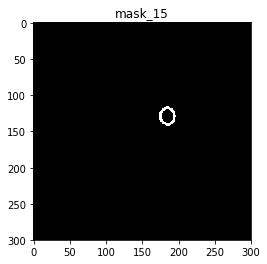

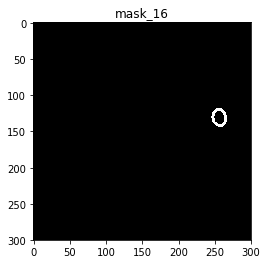

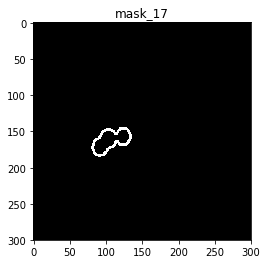

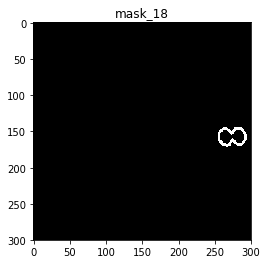

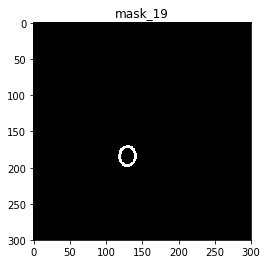

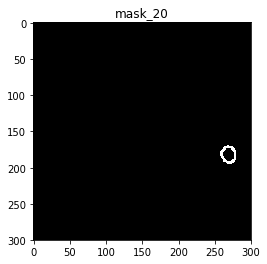

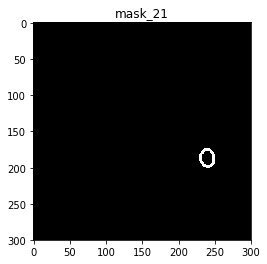

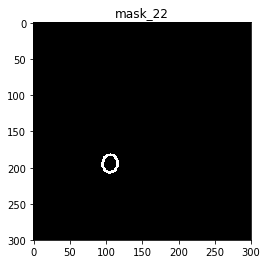

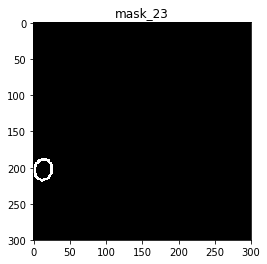

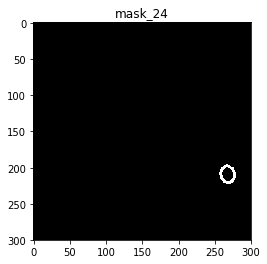

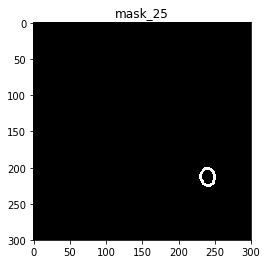

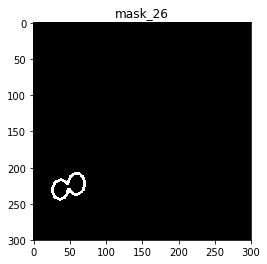

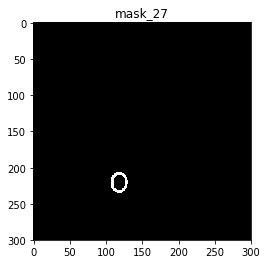

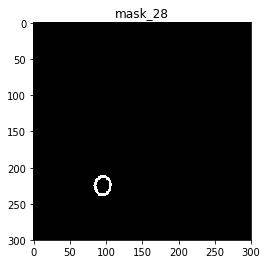

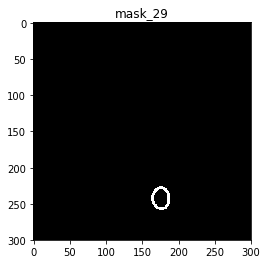

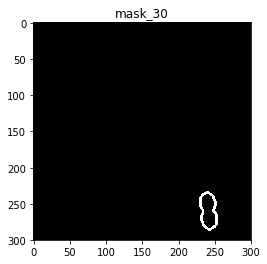

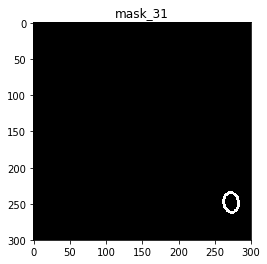

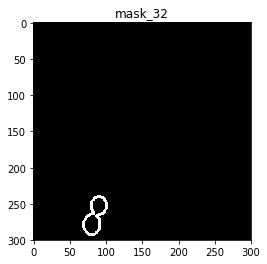

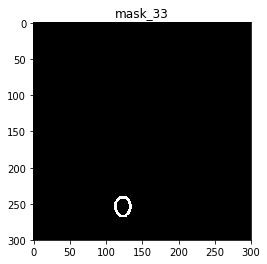

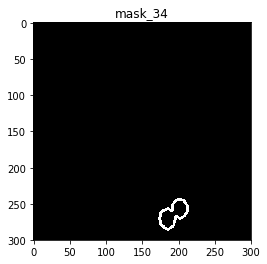

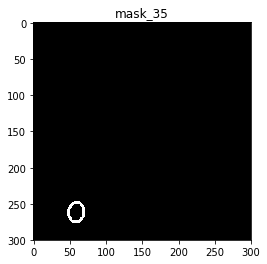

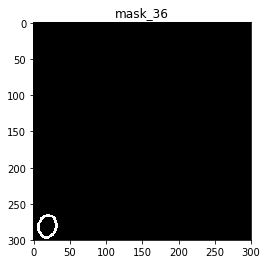

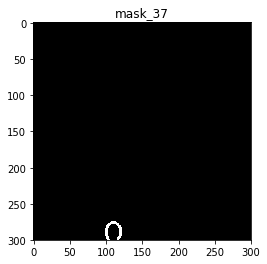

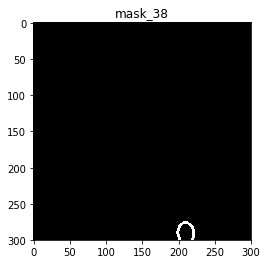

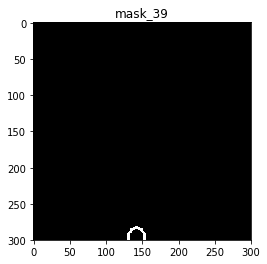

In [22]:
import pickle
kps = {}
rhos = {}
masks = {}
grads = {}
for i in np.unique(labelled_mask):
    
    mask = labelled_mask==i
    
    edgels = canny(h=3,w=3,th=.1)
    edgels.fit(1*mask[np.newaxis,np.newaxis,:,:],nonMaxSup=False)
   
    Ix = edgels.R[0]
    Iy = edgels.R[1]

    rho = np.arctan2(Iy,Ix)
    rho[rho<0]+=2*np.pi
    
    plt.figure()
    plt.title('mask_'+str(i))
    plt.imshow(edgels.mask,**{'cmap':'gray'})
    
    kps[i]=np.nonzero(rho)
    rhos[i]=rho[kps[i]]
    masks[i] = mask*1
    grads[i] = {"Ix":edgels.R[0],"Iy":edgels.R[1],"S":edgels.S,"n":edgels.n}


In [17]:
edgels = {'kps':kps,'rhos':rhos,'masks':masks,'grads':grads}
plt.close()
f = open('data/coin_data/edgels.pickle','wb')
pickle.dump(edgels,f)

In [18]:
#rhos[1][rhos[1]<0]+=2*np.pi

X = kps[1][0] #w
Y = kps[1][1] #h
U = np.cos(rhos[1])
V = np.sin(rhos[1])
X.shape,Y.shape,U.shape

((200,), (200,), (200,))

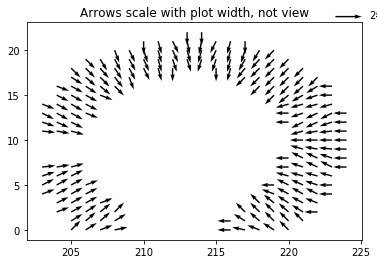

In [19]:
fig1 , ax1 = plt.subplots()
ax1.set_title('Arrows scale with plot width, not view') 
Q=ax1.quiver( Y, X , U  , V, units = 'width' ) 
qk=ax1.quiverkey( Q , 0.9 , 0.9 , 2 , r'$2 \frac{m}{s}$', labelpos = 'E' , coordinates = 'figure' ) 